Cargando y preparando los datos...
Distribución de la variable 'Diabetes_binary':
Diabetes_binary
0    0.842412
1    0.157588
Name: proportion, dtype: float64

Iniciando la optimización de hiperparámetros...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Búsqueda finalizada. Evaluando el mejor modelo encontrado...

Mejores parámetros encontrados: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10}
Mejor puntuación AUC-ROC en validación cruzada: 0.8202

--- Reporte de Clasificación OPTIMIZADO (0=Sano, 1=Diabetes) ---

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     21060
           1       0.35      0.74      0.47      3940

    accuracy                           0.74     25000
   macro avg       0.64      0.74      0.65     25000
weighted avg       0.85      0.74      0.77     25000

Puntuación AUC-RO

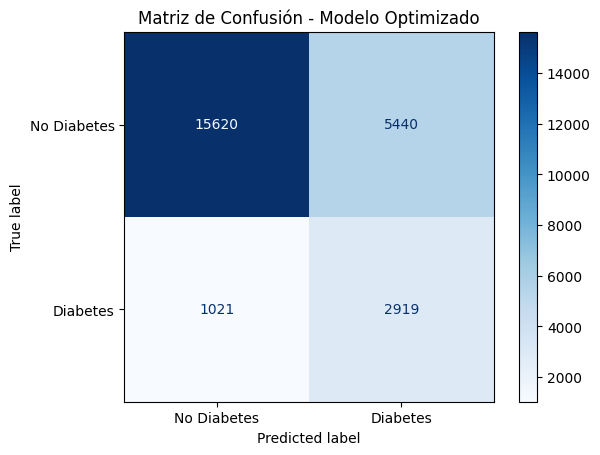

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- 1. Carga y Preparación de Datos ---
print("Cargando y preparando los datos...")
df = pd.read_csv("../Datasets/diabetes_012_health_indicators_BRFSS2015.csv")

# Creación de la variable objetivo binaria: 0 = No Diabetes, 1 = Diabetes (cualquier tipo)
df['Diabetes_binary'] = np.where(df['Diabetes_012'] == 0, 0, 1)
df = df.drop('Diabetes_012', axis=1)

X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

print("Distribución de la variable 'Diabetes_binary':")
print(y.value_counts(normalize=True))


# --- 2. División en Entrenamiento y Prueba ---
# Usamos una muestra de 100,000 para que la optimización sea relativamente rápida.
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=min(100000, len(df)), stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.25, stratify=y_sample, random_state=42
)


# --- 3. Creación del Pipeline ---
# El pipeline es el mismo, pero ahora servirá como base para la búsqueda.
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced', # Mantenemos el manejo del desbalance
        n_jobs=-1
    ))
])


# --- 4. OPTIMIZACIÓN: Búsqueda de Hiperparámetros ---
print("\nIniciando la optimización de hiperparámetros...")

# Definimos el espacio de parámetros que RandomizedSearchCV explorará.
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'] # Opciones comunes para max_features
}

# Usamos validación cruzada estratificada para asegurar que cada "fold" tenga
# una proporción similar de clases.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Configuración de la búsqueda aleatoria.
# n_iter=20 significa que probará 20 combinaciones diferentes. Puedes aumentarlo para una
# búsqueda más exhaustiva, pero tardará más.
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc', # La métrica que queremos maximizar
    cv=cv,
    verbose=1, # Muestra el progreso
    random_state=42,
    n_jobs=-1
)

# Ejecutamos la búsqueda en el conjunto de entrenamiento.
random_search.fit(X_train, y_train)


# --- 5. Evaluación del Modelo OPTIMIZADO ---
print("\nBúsqueda finalizada. Evaluando el mejor modelo encontrado...")

# Obtenemos el mejor modelo del proceso de búsqueda.
best_model = random_search.best_estimator_

print(f"\nMejores parámetros encontrados: {random_search.best_params_}")
print(f"Mejor puntuación AUC-ROC en validación cruzada: {random_search.best_score_:.4f}")

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


# --- Reporte de Clasificación Final ---
print("\n--- Reporte de Clasificación OPTIMIZADO (0=Sano, 1=Diabetes) ---\n")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"Puntuación AUC-ROC en el conjunto de prueba: {auc:.4f}")

# --- Matriz de Confusión Final ---
print("\nGenerando la matriz de confusión del modelo optimizado...")
disp = ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test,
    display_labels=['No Diabetes', 'Diabetes'],
    cmap=plt.cm.Blues
)
disp.ax_.set_title("Matriz de Confusión - Modelo Optimizado")
plt.show()